## 0. Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


In [2]:
torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

## 1. Load Data

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainsetwhole = CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = CIFAR10(root='./data', train=False, download=True, transform=transform)
# testloader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = trainsetwhole.classes

class_count = {}
for _, index in trainsetwhole:
    label = classes[index]
    class_count[label] = class_count.get(label, 0) + 1
    
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [5]:
# Generate reduced training and validation sets
train_data_size = int(len(trainsetwhole) * 0.8)
val_data_size = len(trainsetwhole) - train_data_size
train_data, val_data = torch.utils.data.random_split(trainsetwhole,
                                    [train_data_size, val_data_size],
                                    generator=torch.Generator().manual_seed(42))

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,
                                          shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(val_data, batch_size=64,
                                         shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

print(f"Size of train: {len(trainloader.sampler)}, Size of val: {len(validloader.sampler)}, " \
       f"Size of test: {len(testloader.sampler)}")

Size of train: 40000, Size of val: 10000, Size of test: 10000


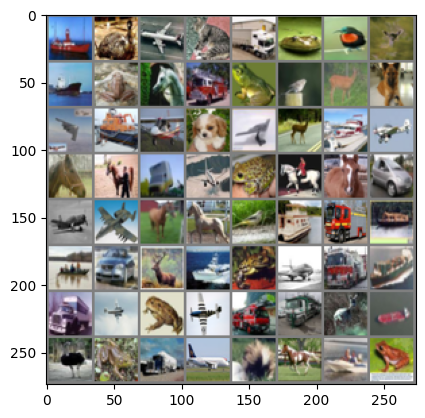

In [22]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#  show graph of train_data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## Create Baseline Model

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [7]:
# Fixed parameters
num_of_classes = 10
num_of_channels = 3

# Hyperparameters
learning_rate = 0.01
batch_size = 32
num_of_epochs = 30
loss_criterion = nn.CrossEntropyLoss()

In [8]:
def get_activation_function(activation_function):
    # decide activation function
    actfn = nn.ReLU()
    if activation_function == "selu":
        actfn = nn.SELU()
    elif activation_function == "elu":
        actfn = nn.ELU()
    else:
        actfn = nn.ReLU()

    return actfn

def get_optimizer(model, optimizer, learning_rate, momentum = 0, weight_decay = 0):
   
    opt = None
    if optimizer == "Adam":
        opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == "NAdam":
        opt = torch.optim.NAdam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum, weight_decay=weight_decay)

    return opt

In [9]:
# Train and calculate loss and accuracy for one epoch
def train(epoch, train_load, model, optimizer):
    training_loss = 0
    training_accuracy = 0

    # Training mode
    model.train()
    for (X_train, y_train) in train_load:
         
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        # Forward
        training_scores = model(X_train)
        loss = loss_criterion(training_scores, y_train)
        training_loss += loss.item()
        training_accuracy += (training_scores.argmax(1) == y_train).sum().item()

        # Clear grads
        optimizer.zero_grad()

        # Backward
        loss.backward()

        # Gradient descent
        optimizer.step()

    # Calculate epoch loss and accuracy
    training_loss = training_loss / len(train_load)
    training_accuracy = training_accuracy / len(train_load.dataset)
    return training_loss, training_accuracy, model

def test(epoch, val_load, model):
    validation_loss = 0
    validation_accuracy = 0

    # Evaluation on the validation data, same process as the training data, but without any backpropagation and optimization
    with torch.no_grad():
        model.eval()
        for (X_val, y_val) in val_load:
            # Move features and labels to GPU
            X_val = X_val.to(device)
            y_val = y_val.to(device)

            # Forward
            validation_scores = model(X_val)
            loss = loss_criterion(validation_scores, y_val)
            validation_loss += loss.item()
            validation_accuracy += (validation_scores.argmax(1) == y_val).sum().item()

    # Calculate epoch loss and accuracy
    validation_loss = validation_loss / len(val_load)
    validation_accuracy = validation_accuracy / len(val_load.dataset)
    return validation_loss, validation_accuracy

# Function to perform a full training run
def train_model(model, optimizer, num_of_epochs, train_load, val_load, patience=3, early_stopping=False):
    
    model.to(device)
    # Train the model
    training_losses = []
    validation_losses = []
    training_accuracies = []
    validation_accuracies = []

    # Early stopping trackers
    trigger_times = 0
    current_val_accuracy = 0
    best_epoch = 0

    for epoch in range(num_of_epochs):
        # Train model and keep track of losses
        training_loss, training_accuracy, model = train(
            epoch, train_load, model, optimizer)
        validation_loss, validation_accuracy = test(epoch, val_load, model)

        # Track early stopping condition
        if validation_accuracy < current_val_accuracy:
            trigger_times += 1
        else:
            current_val_accuracy = validation_accuracy
            best_epoch = epoch
            trigger_times = 0

        if (trigger_times == patience) and early_stopping:
            print("Early stopped!")
            break

        training_losses.append(training_loss)
        validation_losses.append(validation_loss)
        training_accuracies.append(training_accuracy)
        validation_accuracies.append(validation_accuracy)
        
        print(f"Epoch {epoch+1} training loss={round(training_loss,3)}, training accuracy={round(training_accuracy,3)}, validation loss= {round(validation_loss,3)}, validation accuracy={round(validation_accuracy,3)}")


    if (trigger_times == patience) and early_stopping:
        training_losses = training_losses[0:best_epoch + 1].copy()
        validation_losses = validation_losses[0:best_epoch + 1].copy()
        training_accuracies = training_accuracies[0:best_epoch + 1].copy()
        validation_accuracies = validation_accuracies[0:best_epoch + 1].copy()

    print('Minimum Loss: ', round(min(training_losses),3))
    print('Maximum Training Accuracy: ', round(max(training_accuracies),3))
    print('Maximum Validation Accuracy: ',round(max(validation_accuracies),3))    

    show_plot(training_losses, validation_losses, training_accuracies, validation_accuracies)

    return (model, training_losses, validation_losses, training_accuracies, validation_accuracies)


# Show plots of losses and accuracies for training and validation
def show_plot(training_losses, validation_losses, training_accuracies, validation_accuracies):
    
    plt.plot(range(1, len(training_losses)+1), training_accuracies, 'b', range(1,len(training_losses)+1), validation_accuracies, 'orange')
    plt.legend(['training accuracy','validation accuracy'])
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

    plt.plot(range(1, len(training_losses)+1), training_losses, 'b', range(1,len(training_losses)+1), validation_losses, 'orange')
    plt.legend(['training loss','validation loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()



In [24]:
def create_model_baseline(activation_function, optimizer, learning_rate):
    # decide activation function
    actfn = get_activation_function(activation_function)

    # Model creation
    baseline_model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(baseline_model, optimizer, learning_rate)

    print(baseline_model)
    return baseline_model, opt

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=512, out_features=10, bias=True)
  (10): Softmax(dim=1)
)
Epoch 1 training loss=2.108, training accuracy=0.346, validation loss= 2.028, validation accuracy=0.428
Epoch 2 training loss=2.005, training accuracy=0.453, validation loss= 1.98, validation accuracy=0.478
Epoch 3 training loss=1.957, training accuracy=0.502, validation loss= 1.931, validation accuracy=0.527
Epoch 4 training loss=1.922, training accuracy=0.538, validation loss= 1.917, validation accuracy=0.541
Epoch 5 training loss=1.894, training accuracy=0.565, validation loss= 1.

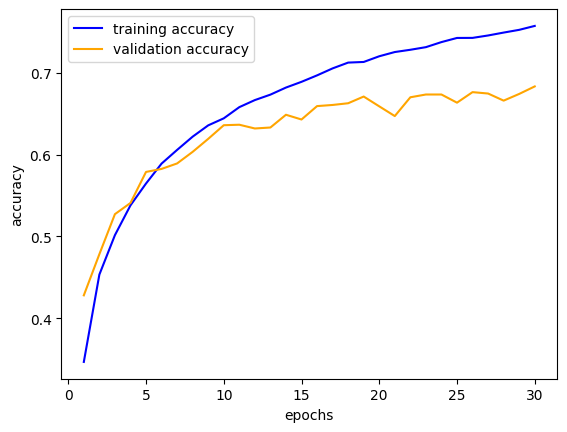

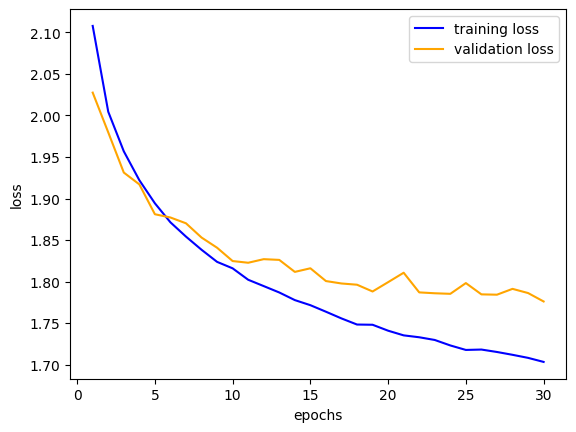

In [26]:
model, optimizer = create_model_baseline("relu", "Adam", 0.001)
_ = train_model(model, optimizer, num_of_epochs, trainloader, validloader, early_stopping=False)

## 1.batch normalization

In [28]:
# build model with batch normalization
def create_model_nom(activation_function, optimizer, learning_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.Flatten(),
        nn.Linear(32 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=512, out_features=10, bias=True)
  (13): Softmax(dim=1)
)
Epoch 1 training loss=1.974, training accuracy=0.501, validation loss= 1.886, validation accuracy=0.587
Epoch 2 training loss=1.847, training accuracy=0.623, validation loss= 1.831, validation accuracy=0.637
Epoch 3 training

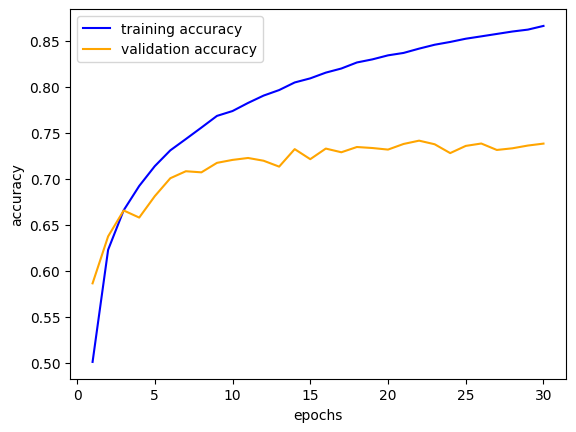

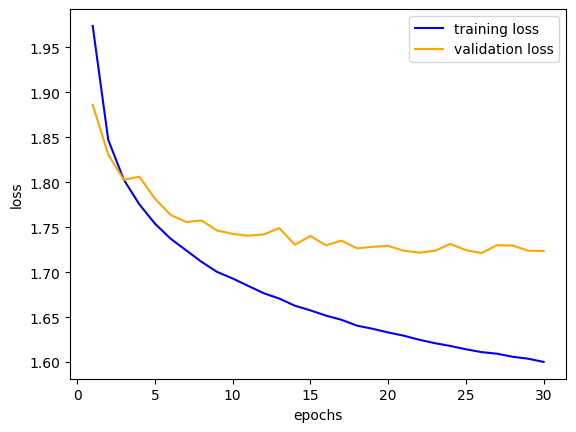

In [29]:
# num_of_epochs
model2, optimizer2 = create_model_nom("relu", "Adam", 0.001)
_ = train_model(model2, optimizer2, 30, trainloader, validloader, early_stopping=False)

## 2.Add dropout layer

In [17]:
# build model with batch normalization
def create_model_drop(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.Dropout(drop_rate),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(32 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=512, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=1.981, training accuracy=0.496, validation loss= 1.936, validation accuracy=0.529
Epoch 2 training loss=1.869, training accura

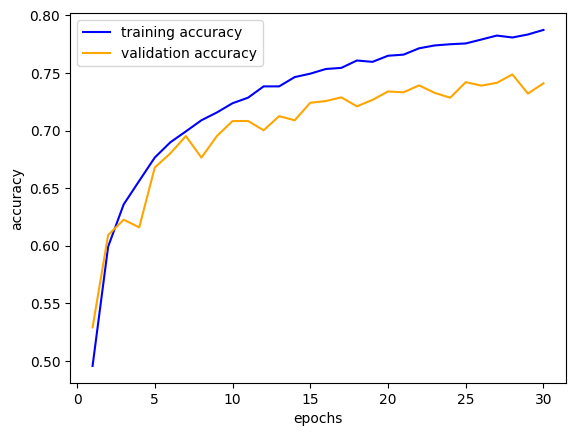

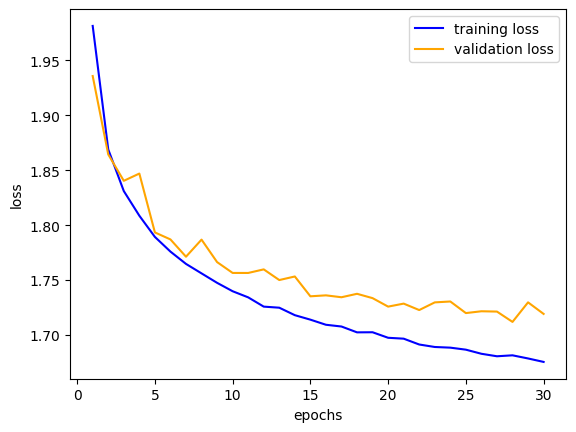

In [20]:
model3, optimizer3 = create_model_drop("relu", "adam", 0.001, 0.2)
_ = train_model(model3, optimizer3, 30, trainloader, validloader, early_stopping=False)

## Change the number of filters

In [7]:
# build model with batch normalization
def create_model_4(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 16, kernel_size=3, stride=1),
        nn.BatchNorm2d(16),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(16, 32, kernel_size=3, stride=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.Dropout(drop_rate),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(64 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=1024, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=1.992, training accuracy=0.476, validation loss= 1.969, validation accuracy=0.499
Epoch 2 training loss=1.883, training accur

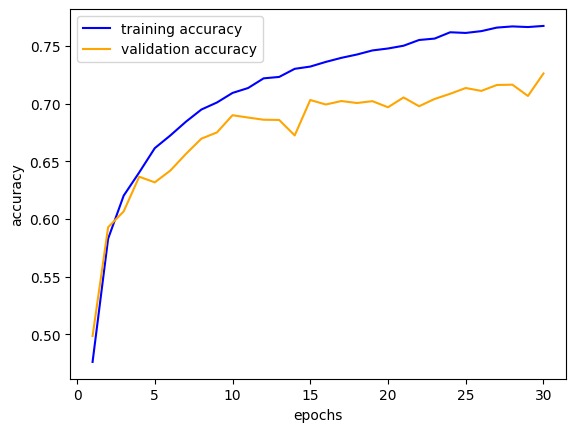

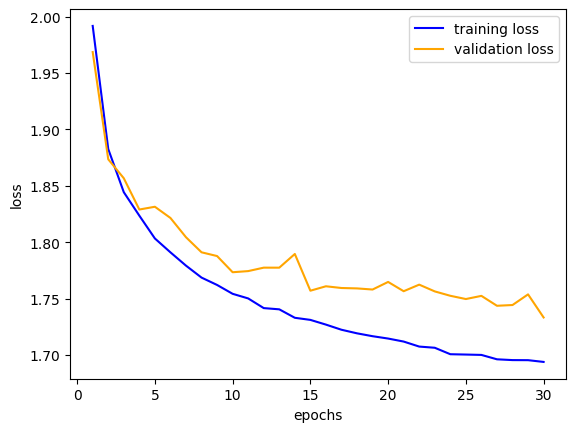

In [16]:
model4, optimizer4 = create_model_4("relu", "Adam", 0.001, 0.2)
_ = train_model(model4, optimizer4, 30, trainloader, validloader, early_stopping=False)

In [17]:
# 64-128-256
def create_model_5(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.Dropout(drop_rate),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1),
        nn.BatchNorm2d(256),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.027, training accuracy=0.428, validation loss= 1.986, validation accuracy=0.467
Epoch 2 training loss=1.926, training 

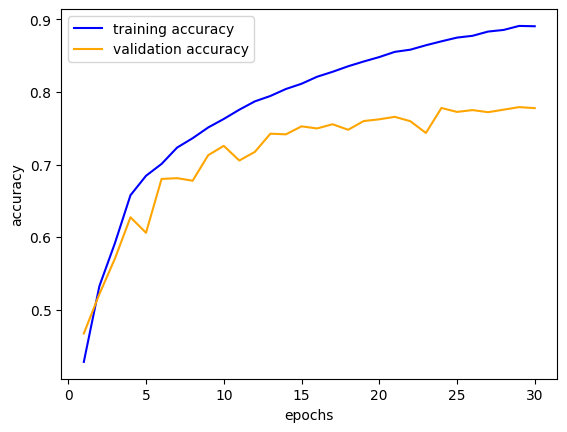

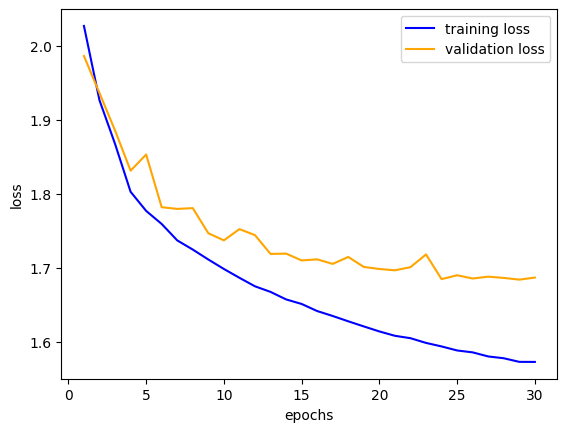

In [18]:
model5, optimizer5 = create_model_5("relu", "Adam", 0.001, 0.2)
_ = train_model(model5, optimizer5, 30, trainloader, validloader, early_stopping=False)

In [47]:
# build model with batch normalization
def create_model_6(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 32, kernel_size=3, stride=1, padding=1),
        actfn,
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(16 * 8 * 8, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU()
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): Dropout(p=0.2, inplace=False)
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=1024, out_features=10, bias=True)
  (16): Softmax(dim=1)
)
Epoch 1 training loss=1.969, training accuracy=0

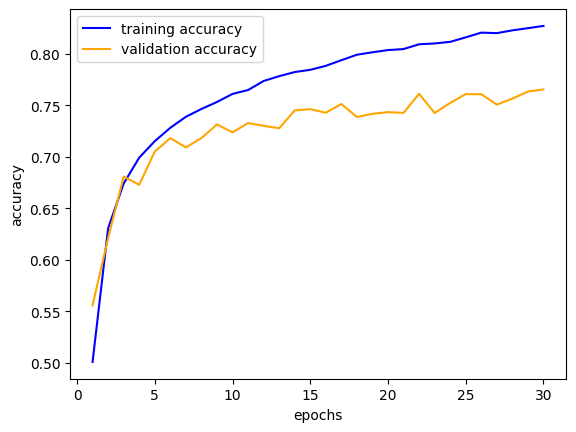

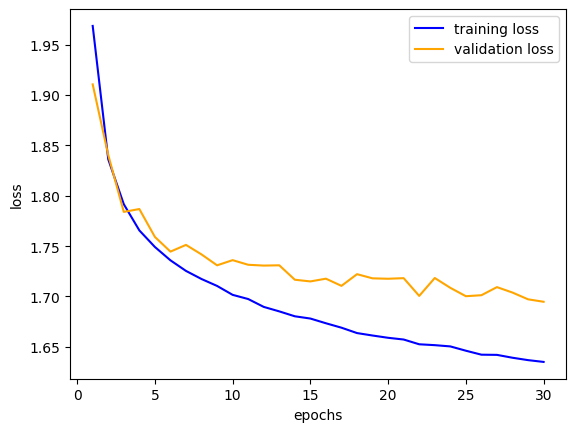

In [49]:
model6, optimizer6 = create_model_6("relu", "Adam", 0.001, 0.2)
_ = train_model(model6, optimizer6, 30, trainloader, validloader, early_stopping=False)

## Change learning rate

In [11]:
# 64-128-256
def create_model_5(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.Dropout(drop_rate),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1),
        nn.BatchNorm2d(256),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.266, training accuracy=0.194, validation loss= 2.25, validation accuracy=0.21
Epoch 2 training loss=2.284, training ac

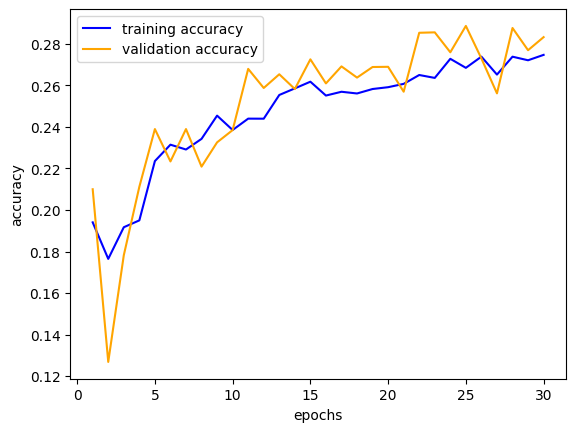

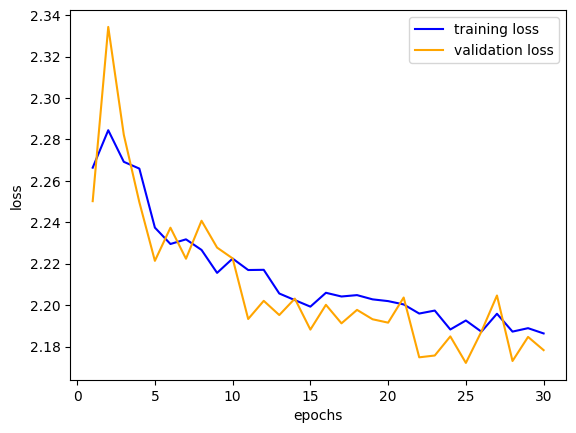

In [12]:
model, optimizer = create_model_5("relu", "Adam", 0.01, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.018, training accuracy=0.471, validation loss= 1.943, validation accuracy=0.539
Epoch 2 training loss=1.878, training 

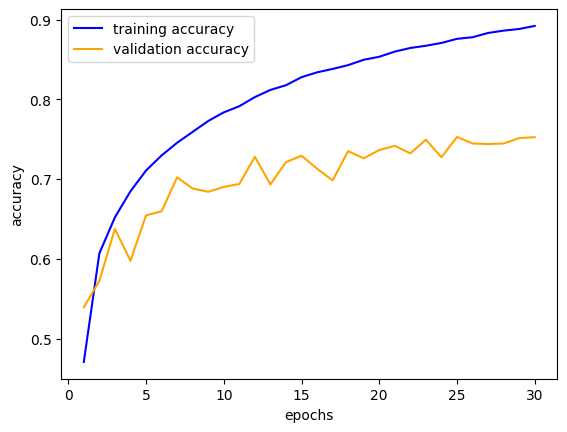

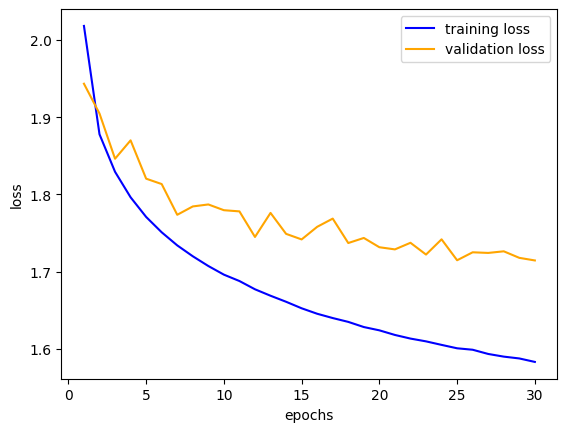

In [13]:
model, optimizer = create_model_5("relu", "Adam", 0.0001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

## optimer and decay

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=1.968, training accuracy=0.49, validation loss= 1.912, validation accuracy=0.546
Epoch 2 training loss=1.845, training a

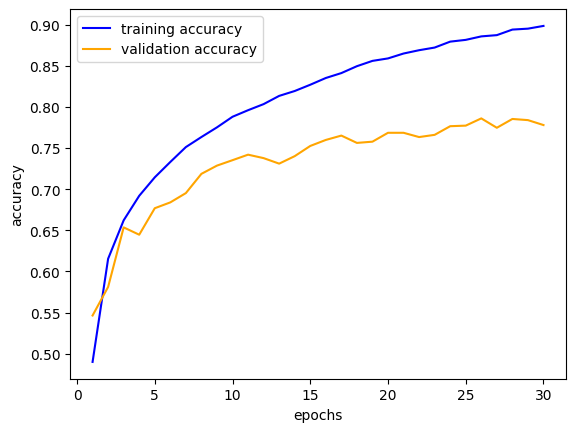

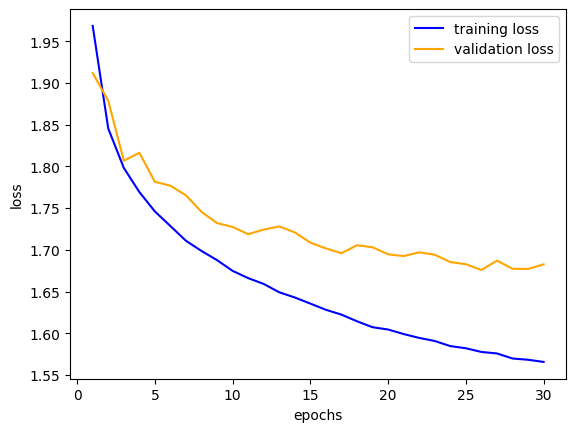

In [14]:
model, optimizer = create_model_5("relu", "NAdam", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.274, training accuracy=0.193, validation loss= 2.247, validation accuracy=0.262
Epoch 2 training loss=2.212, training 

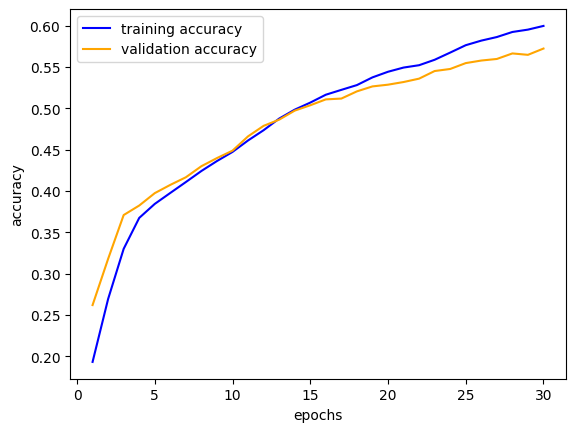

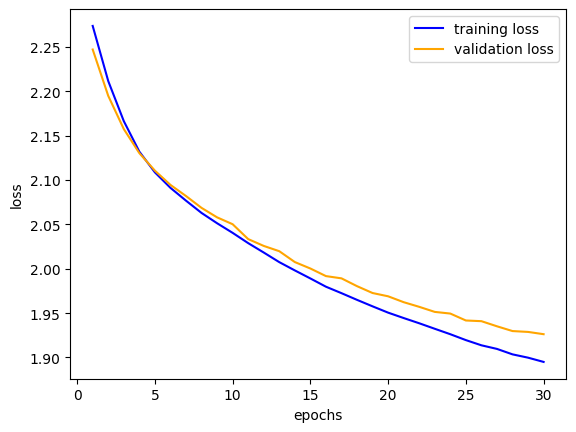

In [25]:
model, optimizer = create_model_5("relu", "SGD", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SELU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SELU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.039, training accuracy=0.416, validation loss= 2.012, validation accuracy=0.447
Epoch 2 training loss=1.969, training 

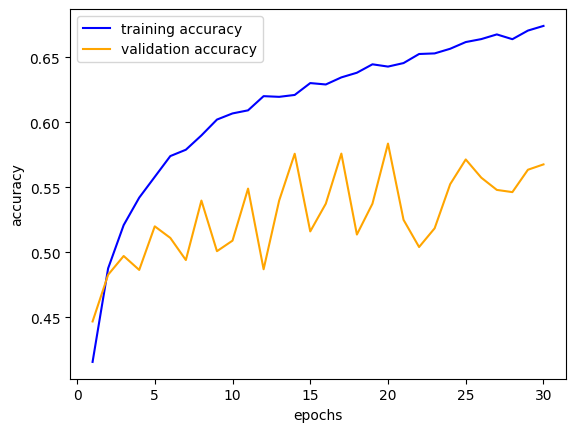

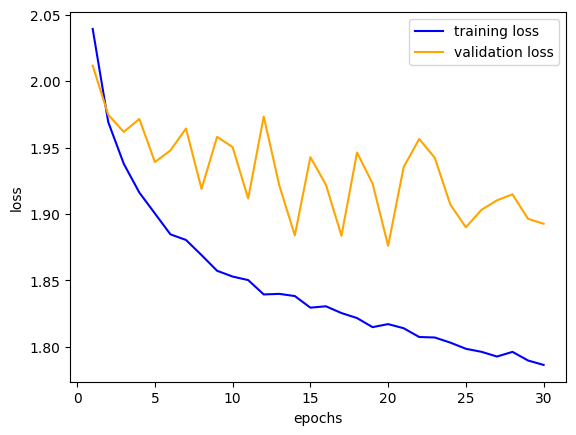

In [27]:
model, optimizer = create_model_5("selu", "Adam", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ELU(alpha=1.0)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ELU(alpha=1.0)
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ELU(alpha=1.0)
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=1.998, training accuracy=0.459, validation loss= 1.958, validation accuracy=0.497
Epoch 2 traini

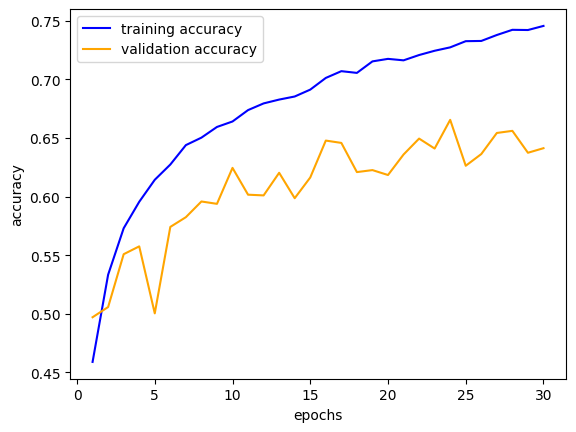

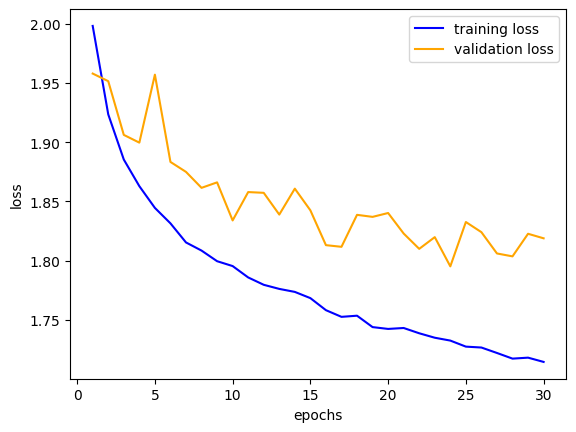

In [28]:
model, optimizer = create_model_5("elu", "Adam", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SELU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SELU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.004, training accuracy=0.452, validation loss= 2.018, validation accuracy=0.439
Epoch 2 training loss=1.934, training 

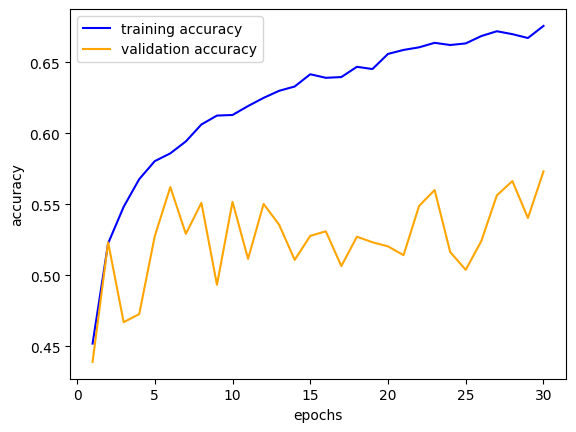

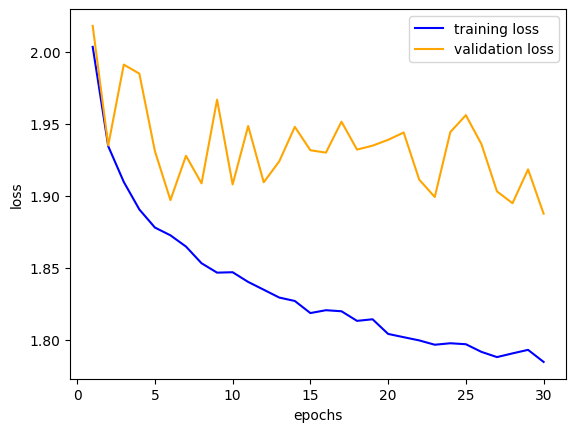

In [31]:
model, optimizer = create_model_5("selu", "NAdam", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ELU(alpha=1.0)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ELU(alpha=1.0)
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ELU(alpha=1.0)
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=1.986, training accuracy=0.47, validation loss= 1.954, validation accuracy=0.502
Epoch 2 trainin

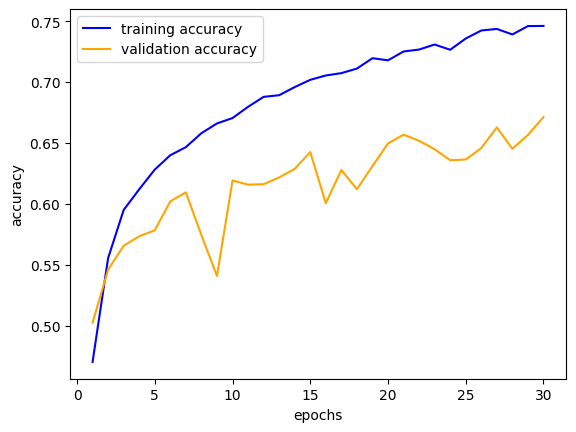

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000018D440448B0>
Traceback (most recent call last):
  File "c:\Users\zhc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\zhc\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


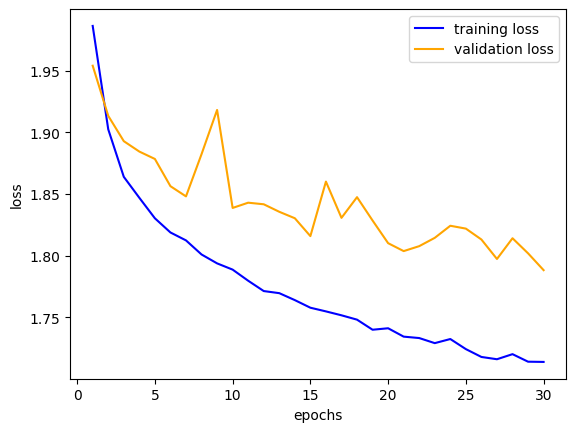

In [32]:
model, optimizer = create_model_5("elu", "NAdam", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SELU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SELU()
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): SELU()
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.215, training accuracy=0.256, validation loss= 2.151, validation accuracy=0.338
Epoch 2 training loss=2.124, training 

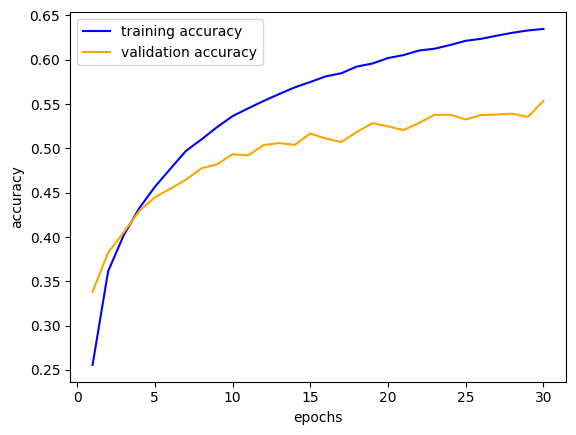

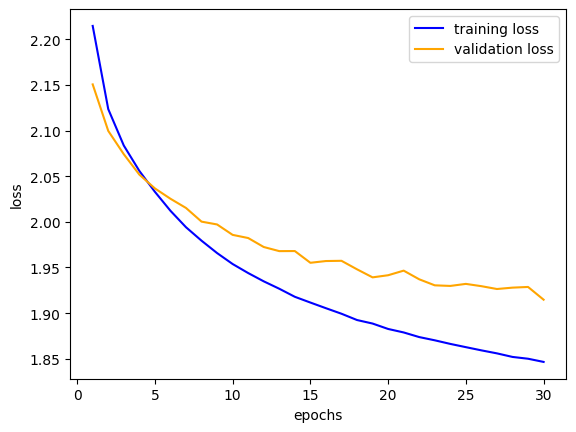

In [33]:
model, optimizer = create_model_5("selu", "SGD", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ELU(alpha=1.0)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ELU(alpha=1.0)
  (7): Dropout(p=0.2, inplace=False)
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ELU(alpha=1.0)
  (12): Dropout(p=0.2, inplace=False)
  (13): Flatten(start_dim=1, end_dim=-1)
  (14): Linear(in_features=4096, out_features=10, bias=True)
  (15): Softmax(dim=1)
)
Epoch 1 training loss=2.24, training accuracy=0.238, validation loss= 2.185, validation accuracy=0.31
Epoch 2 training

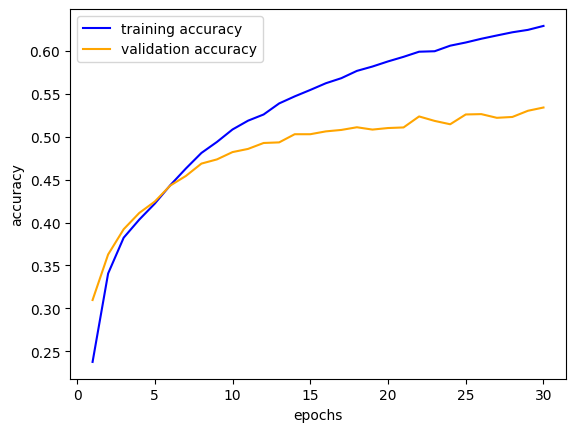

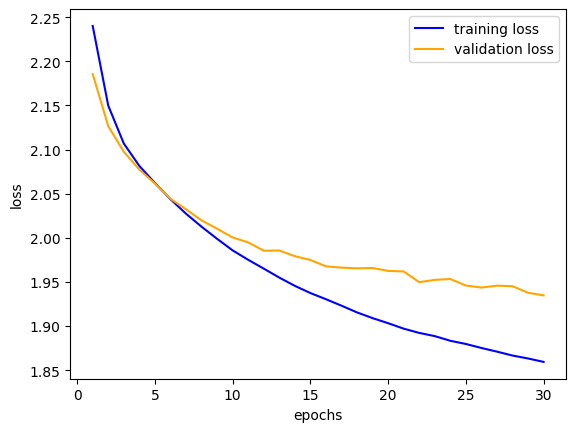

In [34]:
model, optimizer = create_model_5("elu", "SGD", 0.001, 0.2)
_ = train_model(model, optimizer, 30, trainloader, validloader, early_stopping=False)

In [ ]:
def create_model_5(activation_function, optimizer, learning_rate, drop_rate):
    
    actfn = get_activation_function(activation_function)

    # Model creation
    model = nn.Sequential(
        nn.Conv2d(num_of_channels, 64, kernel_size=3, stride=1),
        nn.BatchNorm2d(64),
        actfn,
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, stride=1),
        nn.BatchNorm2d(128),
        actfn,
        nn.Dropout(drop_rate),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(128, 256, kernel_size=3, stride=1),
        nn.BatchNorm2d(256),
        actfn,
        nn.Dropout(drop_rate),
        nn.Flatten(),
        nn.Linear(256 * 4 * 4, 10),
        nn.Softmax(1)
    ).to(device)

    # decide optimizer
    opt = get_optimizer(model, optimizer, learning_rate)

    print(model)
    return model, opt

In [ ]:
# change model add decay
model5, optimizer5 = create_model_5("relu", "Adam", 0.001, 0.2)
_ = train_model(model5, optimizer5, 30, trainloader, validloader, early_stopping=False)

## Image Augmentation

In [20]:
from sklearn.model_selection import train_test_split

augment_transform_sequence = transforms.Compose([
    # transforms.CenterCrop((24, 24)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.GaussianBlur(kernel_size=(5, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Full training set augmented
full_train_data_augmented = CIFAR10(
    root="dataset_augmented/", train=True, transform=augment_transform_sequence, download=True)

# Split dataset into train and validation
train_indices, _ = train_test_split(
    list(range(len(full_train_data_augmented.targets))), test_size=0.8, stratify=full_train_data_augmented.targets)

train_dataset_extra = torch.utils.data.Subset(full_train_data_augmented, train_indices)
train_data_augmented = torch.utils.data.ConcatDataset(
    [train_dataset_extra, train_data])

# Create augmented train loader
train_load_augmented = torch.utils.data.DataLoader(
    dataset=train_data_augmented, batch_size=batch_size, shuffle=True)

print("Lenth of augmented train data =", len(train_data_augmented))


Files already downloaded and verified
Lenth of augmented train data = 50000


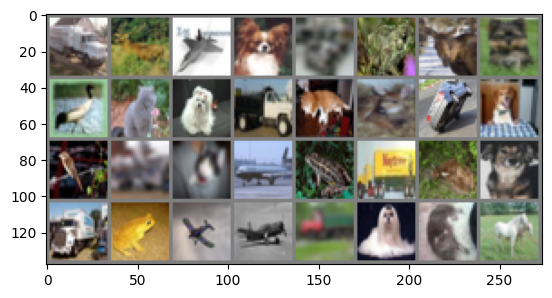

In [23]:
# get some random training images
dataiter = iter(train_load_augmented)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#  show graph of train_data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

## On the test set